# Multi-label classification of racial tweets:

In [1]:
#Get directory path
import os
os.chdir('/Users/valery/Documents/Springboard/Capstone_2') 
os.getcwd( )

'/Users/valery/Documents/Springboard/Capstone_2'

In [2]:
import pandas as pd
#Read in csv of cleaned data
df = pd.read_csv('df_tweets.csv', index_col=0)

#Create training set
df_train = df[df['tweet'].notnull()]
print(df_train.shape)
print('')
print(df_train.columns)
df_train.head()

(6481, 5)

Index(['tweetidg', 'tweet', 'positive', 'negative', 'neutral'], dtype='object')


,tweetidg,tweet,positive,negative,neutral
0,588687492888551424g,i am the type of nigga tryna get rich,0.0,0.0,1.0
1,592553981601304576g,sheblasiannn smuckers,0.0,0.0,1.0
2,717371522956984320g,proteinwisdom we even make japanese cars and e...,0.0,0.0,1.0
3,590292541125328898g,i wanted to see my nigga when i went back home...,0.0,1.0,0.0
4,592522044480225282g,wth stevo is that a nigga,0.0,0.0,1.0


In [3]:
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

### Create a table to examine the distribution of tags

In [4]:
df_train.columns

Index(['tweetidg', 'tweet', 'positive', 'negative', 'neutral'], dtype='object')

In [5]:
df_sparse = df_train.drop(['tweetidg', 'tweet'], axis=1)

counts = []
priors = []
categories = list(df_sparse.columns.values)
for i in categories:
    numarts = df_sparse[i].sum()
    counts.append((i, numarts))

df_stats = pd.DataFrame(counts, columns=['Category', 'Number_of_Tweets'])
total = df_stats.Number_of_Tweets.sum()

df_stats['priors'] = df_stats['Number_of_Tweets']/total

print(df_stats)
print('')
print('Total number of labels:  ', total)

   Category  Number_of_Tweets    priors
0  positive            1642.0  0.253356
1  negative            1977.0  0.305046
2   neutral            2862.0  0.441599

Total number of labels:   6481.0


## Multi-label classification

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
df_train.columns

Index(['tweetidg', 'tweet', 'positive', 'negative', 'neutral'], dtype='object')

In [8]:
#Make sure all entries in df_matrix['text'] are strings
df_train['tweet'] = df_train['tweet'].astype(str)
categories = ['positive', 'negative', 'neutral']

In [9]:
#Vectorize the data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     #min_df=1,strip_accents='unicode',max_features=200)

#featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
#X = featurizer.fit_transform(df_train.tweet)

## Multinomial Naive Bayes

In [10]:
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = vectorizer.fit_transform(df_train.tweet)

clf_NB = MultinomialNB()

for category in categories:
    y = df_train[category].values.astype(np.int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    clf_NB.fit(X_train,y_train)

    train_accuracy =clf_NB.score(X_train,y_train)
    test_accuracy = clf_NB.score(X_test, y_test)
    print(category, "training set accuracy: ", train_accuracy)
    print(category, "test set accuracy: ", test_accuracy, '\n')
          

positive training set accuracy:  0.7654320987654321
positive test set accuracy:  0.7552699228791774 

negative training set accuracy:  0.7795414462081128
negative test set accuracy:  0.7588688946015424 

neutral training set accuracy:  0.6664462081128748
neutral test set accuracy:  0.6627249357326478 



This is looking good! But accuracy can be deceiving. High accuracy scores can still happen if your model detects many true negatives, but few true positives! Let's check:

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

X = vectorizer.fit_transform(df_train.tweet)


conmatrxNB = []
precisionNB = []
recallNB = []
f1NB = []


for category in categories:
    
    y_train_pred = cross_val_predict(clf_NB, X, df_train[category], cv=5)
    
    cmNB = confusion_matrix(df_train[category], y_train_pred)
    conmatrxNB.append(cmNB)
    precNB = precision_score(df_train[category], y_train_pred)    
    precisionNB.append(precNB)
    recNB = recall_score(df_train[category], y_train_pred)
    recallNB.append(recNB)
    fNB = f1_score(df_train[category], y_train_pred)
    f1NB.append(fNB)

    
dictNB = {'Categories':categories, 'Confusion Matrix':conmatrxNB, 'Precision_NB':precisionNB, 'Recall_NB':recallNB, 'F1_NB':f1NB}
df_NB = pd.DataFrame(dictNB) 
#df_NB.to_csv('/Users/valery/Documents/Springboard/Capstone_2/Pretuned_Results/Results_NB_tweets.csv')

df_NB_tweets = df_NB[df_NB['Precision_NB'] >= 0]
 
df_NB_tweets

,Categories,Confusion Matrix,Precision_NB,Recall_NB,F1_NB
0,positive,"[[4150, 689], [1083, 559]]",0.447917,0.340438,0.386851
1,negative,"[[3521, 983], [535, 1442]]",0.594639,0.729388,0.655157
2,neutral,"[[3017, 602], [1621, 1241]]",0.673359,0.433613,0.527524


As I expected, high accuracy doesn't always mean high precision or recall. We can see that these are lower. I will run the other models first, then tune parameters on the one showing the most promise for this data. Note that for the neutral label, accuracy was lower than precision. For this study, we want to decrease the probability of a Type 2 error - a false positive where we say there is an effect but there is not. Precision is the best score to tune because it is a measure of how sure we are that a label is a true label (true positive) if our algorithm classifies it as such. After running the other two classifiers, I will tune the hyper-parameters for the best performing classifier at these default settings. 

## LinearSVC

In [65]:
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = featurizer.fit_transform(df_train.tweet)

clf_SVC = LinearSVC()

conmatrxSVC = []
precisionSVC = []
recallSVC = []
f1SVC = []

for category in categories:

    y_train_pred = cross_val_predict(clf_SVC, X, df_train[category], cv=5)
    
    cmSVC = confusion_matrix(df_train[category], y_train_pred)
    conmatrxSVC.append(cmSVC)
    precSVC = precision_score(df_train[category], y_train_pred)    
    precisionSVC.append(precSVC)
    recSVC = recall_score(df_train[category], y_train_pred)
    recallSVC.append(recSVC)
    fSVC = f1_score(df_train[category], y_train_pred)
    f1SVC.append(fSVC)

    
dictSVC = {'Categories':categories, 'Confusion Matrix':conmatrxSVC, 'Precision_SVC':precisionSVC, 
           'Recall_SVC':recallSVC, 'F1_SVC':f1SVC}
df_SVC = pd.DataFrame(dictSVC) 
#df_SVC.to_csv('/Users/valery/Documents/Springboard/Capstone_2/Pretuned_Results/Results_SVC_tweets.csv')

df_SVC_tweets = df_SVC[df_SVC['Precision_SVC'] >= 0]
 
df_SVC_tweets

,Categories,Confusion Matrix,Precision_SVC,Recall_SVC,F1_SVC
0,positive,"[[4510, 329], [1265, 377]]",0.533994,0.229598,0.321124
1,negative,"[[3967, 537], [855, 1122]]",0.676311,0.567527,0.617162
2,neutral,"[[2791, 828], [1289, 1573]]",0.655144,0.549616,0.597758


## Logistic Regression

In [67]:
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = featurizer.fit_transform(df_train.tweet)


clf_LR = LogisticRegression()

import warnings
warnings.filterwarnings("ignore")

#Prediction with NB
conmatrxLR = []
precisionLR = []
recallLR = []
f1LR = []



for category in categories:

    y_train_pred = cross_val_predict(clf_LR, X, df_train[category], cv=5)
    
    cmLR = confusion_matrix(df_train[category], y_train_pred)
    conmatrxLR.append(cmLR)
    precLR = precision_score(df_train[category], y_train_pred)    
    precisionLR.append(precLR)
    recLR = recall_score(df_train[category], y_train_pred)
    recallLR.append(recLR)
    fLR = f1_score(df_train[category], y_train_pred)
    f1LR.append(fLR)

    
dictLR = {'Categories':categories, 'Confusion Matrix':conmatrxLR, 'Precision_LR':precisionLR,'Recall_LR':recallLR, 'F1_LR':f1LR}
df_LR = pd.DataFrame(dictLR) 
#df_LR.to_csv('/Users/valery/Documents/Springboard/Capstone_2/Pretuned_Results/Results_LR_tweets.csv')

df_LR_tweets = df_LR[df_LR['Precision_LR'] >= 0]
 
df_LR_tweets

,Categories,Confusion Matrix,Precision_LR,Recall_LR,F1_LR
0,positive,"[[4650, 189], [1333, 309]]",0.620482,0.188185,0.288785
1,negative,"[[4024, 480], [903, 1074]]",0.691120,0.543247,0.608326
2,neutral,"[[2801, 818], [1236, 1626]]",0.665303,0.568134,0.612891


## Random forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = featurizer.fit_transform(df_train.tweet)

clf_RF = RandomForestClassifier()

conmatrxRF = []
precisionRF = []
recallRF = []
f1RF = []

for category in categories:

    y_train_pred = cross_val_predict(clf_RF, X, df_train[category], cv=5)
    
    cmRF = confusion_matrix(df_train[category], y_train_pred)
    conmatrxRF.append(cmRF)
    precRF = precision_score(df_train[category], y_train_pred)    
    precisionRF.append(precRF)
    recRF = recall_score(df_train[category], y_train_pred)
    recallRF.append(recRF)
    fRF = f1_score(df_train[category], y_train_pred)
    f1RF.append(fRF)

    
dictRF = {'Categories':categories, 'Confusion Matrix':conmatrxRF, 'Precision_RF':precisionRF, 
           'Recall_RF':recallRF, 'F1_RF':f1RF}
df_RF = pd.DataFrame(dictRF) 
#df_RF.to_csv('/Users/valery/Documents/Springboard/Capstone_2/Pretuned_Results/Results_RF_tweets.csv')

df_RF_tweets = df_RF[df_RF['Precision_RF'] >= 0]
 
df_RF_tweets

,Categories,Confusion Matrix,Precision_RF,Recall_RF,F1_RF
0,positive,"[[4342, 497], [1243, 399]]",0.445312,0.242996,0.314421
1,negative,"[[3831, 673], [917, 1060]]",0.611656,0.536166,0.571429
2,neutral,"[[2662, 957], [1314, 1548]]",0.617964,0.540881,0.576859


## Gradient Boosting

In [96]:
from sklearn.ensemble import GradientBoostingClassifier

vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = featurizer.fit_transform(df_train.tweet)

clf_GRD = GradientBoostingClassifier()

conmatrxGRD = []
precisionGRD = []
recallGRD = []
f1GRD = []

for category in categories:

    y_train_pred = cross_val_predict(clf_GRD, X, df_train[category], cv=5)
    
    cmGRD = confusion_matrix(df_train[category], y_train_pred)
    conmatrxGRD.append(cmGRD)
    precGRD = precision_score(df_train[category], y_train_pred)    
    precisionGRD.append(precGRD)
    recGRD = recall_score(df_train[category], y_train_pred)
    recallGRD.append(recGRD)
    fGRD = f1_score(df_train[category], y_train_pred)
    f1GRD.append(fGRD)

    
dictGRD = {'Categories':categories, 'Confusion Matrix':conmatrxGRD, 'Precision_GRD':precisionGRD, 
           'Recall_GRD':recallGRD, 'F1_GRD':f1GRD}
df_GRD = pd.DataFrame(dictGRD) 
#df_GRD.to_csv('/Users/valery/Documents/Springboard/Capstone_2/Pretuned_Results/Results_GRD_tweets.csv')

df_GRD_tweets = df_GRD[df_GRD['Precision_GRD'] >= 0]
 
df_GRD_tweets

,Categories,Confusion Matrix,Precision_GRD,Recall_GRD,F1_GRD
0,positive,"[[4720, 119], [1380, 262]]",0.687664,0.159562,0.259021
1,negative,"[[4090, 414], [1075, 902]]",0.685410,0.456247,0.547829
2,neutral,"[[2629, 990], [1097, 1765]]",0.640653,0.616702,0.628449


In [72]:
df_prec1 = pd.DataFrame(columns = ['Categories', 'Precision_NB', 'Precision_SVC', 
                                   'Precision_LR', 'Precision_RF', 'Precision_GRD', 'Max_Precision'])
df_prec1.Categories = df_NB.Categories
df_prec1.Precision_NB = df_NB.Precision_NB
df_prec1.Precision_SVC  = df_SVC.Precision_SVC
df_prec1.Precision_LR  = df_LR.Precision_LR
df_prec1.Precision_RF = df_RF.Precision_RF
df_prec1.Precision_GRD = df_GRD.Precision_GRD


df_prec1.Max_Precision = df_prec1.max(axis=1)

df_prec1.to_csv('/Users/valery/Documents/Springboard/Capstone_2/Pretuned_Results/Pretuned_Precision.csv')

df_prec1

,Categories,Precision_NB,Precision_SVC,Precision_LR,Precision_RF,Precision_GRD,Max_Precision
0,positive,0.447917,0.533994,0.620482,0.445312,0.787356,0.787356
1,negative,0.594639,0.676311,0.691120,0.611656,0.671845,0.691120
2,neutral,0.673359,0.655144,0.665303,0.617964,0.591048,0.673359


In [73]:
df_rec = pd.DataFrame(columns = ['Categories', 'Recall_NB', 'Recall_SVC', 
                                   'Recall_LR', 'Recall_RF', 'Recall_GRD','Max_Recall'])
df_rec.Categories = df_NB.Categories
df_rec.Recall_NB = df_NB.Recall_NB
df_rec.Recall_SVC  = df_SVC.Recall_SVC
df_rec.Recall_LR  = df_LR.Recall_LR
df_rec.Recall_RF = df_RF.Recall_RF
df_rec.Recall_GRD = df_GRD.Recall_GRD
df_rec.Max_Recall = df_rec.max(axis=1)

df_rec.to_csv('/Users/valery/Documents/Springboard/Capstone_2/Pretuned_Results/Pretuned_Recall.csv')

df_rec

,Categories,Recall_NB,Recall_SVC,Recall_LR,Recall_RF,Recall_GRD,Max_Recall
0,positive,0.340438,0.229598,0.188185,0.242996,0.083435,0.340438
1,negative,0.729388,0.567527,0.543247,0.536166,0.350025,0.729388
2,neutral,0.433613,0.549616,0.568134,0.540881,0.673655,0.673655


In [39]:
df_f1 = pd.DataFrame(columns = ['Categories', 'F1_NB', 'F1_SVC', 
                                   'F1_LR', 'F1_RF','F1_GRD','Max_F1'])
df_f1.Categories = df_NB.Categories
df_f1.F1_NB = df_NB.F1_NB
df_f1.F1_SVC  = df_SVC.F1_SVC
df_f1.F1_LR  = df_LR.F1_LR
df_f1.F1_RF  = df_RF.F1_RF
df_f1.F1_GRD  = df_GRD.F1_GRD
df_f1.Max_F1 = df_f1.max(axis=1)

df_f1.to_csv('/Users/valery/Documents/Springboard/Capstone_2/Pretuned_Results/Pretuned_f1.csv')

df_f1

,Categories,F1_NB,F1_SVC,F1_LR,F1_RF,F1_GRD,Max_F1
0,positive,0.287852,0.321124,0.288785,0.331013,0.063011,0.331013
1,negative,0.622292,0.617162,0.608326,0.567753,0.070702,0.622292
2,neutral,0.528157,0.597758,0.612891,0.580085,0.109652,0.612891


## Tune hyperparameters for NB

In [76]:
from sklearn.model_selection import GridSearchCV
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)
X = vectorizer.fit_transform(df_train.tweet)

clf_NB = MultinomialNB()


alphas = [.00001,.0001, .001, .01, .1, 1, 5, 10, 50]


    # Create hyperparameter options
hyperparameters = dict(alpha=alphas)


     # Create grid search using 5-fold cross validation
clf_tune = GridSearchCV(clf_NB, hyperparameters, cv=5, scoring='recall')               

for category in categories:
    # Fit grid search
    best_model = clf_tune.fit(X, df_train[category])                
                
    # View best hyperparameters
    print(category)
    #print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])
    print('Best Alpha:', best_model.best_estimator_.get_params()['alpha'], '\n')


positive
Best Alpha: 1 

negative
Best Alpha: 1e-05 

neutral
Best Alpha: 5 



## Train the tuned Multinomial NB

In [77]:
from sklearn.model_selection import GridSearchCV
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)
X = vectorizer.fit_transform(df_train.tweet)

conmatrxNB = []
precisionNB = []
recallNB = []
f1NB = []

clf_NB = MultinomialNB()

#Create grid of hyperparameters
alphas = [.00001,.0001, .001, .01, .1, 1, 5, 10, 50]

# Create hyperparameter options
hyperparameters = dict(alpha=alphas)

# Create grid search using 5-fold cross validation
clf_tune = GridSearchCV(clf_NB, hyperparameters, cv=5, scoring='recall')        

for category in categories:
    
    # Fit grid search
    best_model = clf_tune.fit(X, df_train[category])                
    alpha = best_model.best_estimator_.get_params()['alpha'] 
    
    #Train the models
    clf_tunedNB = MultinomialNB(alpha=alpha)
            
    y_train_pred = cross_val_predict(clf_tunedNB, X, df_train[category], cv=5)

    
    cmNB = confusion_matrix(df_train[category], y_train_pred)
    conmatrxNB.append(cmNB)
    precNB = precision_score(df_train[category], y_train_pred)    
    precisionNB.append(precNB)
    recNB = recall_score(df_train[category], y_train_pred)
    recallNB.append(recNB)
    fNB = f1_score(df_train[category], y_train_pred)
    f1NB.append(fNB)

    
dictNB = {'Categories':categories, 'Confusion Matrix':conmatrxNB, 'Precision_NB':precisionNB, 
          'Recall_NB':recallNB, 'F1_NB':f1NB}

df_NB = pd.DataFrame(dictNB) 
df_tunedNB_tweets = df_NB[df_NB['/Users/valery/Documents/Springboard/Capstone_2/Tuned_Results/Precision_NB'] >= 0]
 
df_tunedNB_tweets


,Categories,Confusion Matrix,Precision_NB,Recall_NB,F1_NB
0,positive,"[[4150, 689], [1083, 559]]",0.447917,0.340438,0.386851
1,negative,"[[3519, 985], [532, 1445]]",0.594650,0.730905,0.655775
2,neutral,"[[3010, 609], [1613, 1249]]",0.672228,0.436408,0.529237


## Tune hyperparameters for SVC

In [94]:
from sklearn.model_selection import GridSearchCV

vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = vectorizer.fit_transform(df_train.tweet)

clf_SVC = LinearSVC(random_state=42)


loss = ['hinge', 'squared_hinge']
#kernel = ['linear', 'rbf', 'poly']
C = [1, 10, 100, 1000, 10000]


    # Create hyperparameter options
hyperparameters = dict(C=C, loss=loss)


     # Create grid search using 5-fold cross validation
clf_tune = GridSearchCV(clf_SVC, hyperparameters, cv=5, scoring='recall')               

for category in categories:
    # Fit grid search
    best_model = clf_tune.fit(X, df_train[category])                
                
    # View best hyperparameters
    print(category)
    #print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])
    print('Best loss:', best_model.best_estimator_.get_params()['loss'])
    print('Best C:', best_model.best_estimator_.get_params()['C'],'\n')         


positive
Best loss: squared_hinge
Best C: 1000 

negative
Best loss: squared_hinge
Best C: 1000 

neutral
Best loss: hinge
Best C: 10000 



## Train the tuned LinearSVC

In [95]:
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = vectorizer.fit_transform(df_train.tweet)

clf_SVC = LinearSVC(random_state=42)


#Prediciton with NB
conmatrxSVC = []
precisionSVC = []
recallSVC = []
f1SVC = []


for category in categories:
    if category == 'positive':
        clf_tunedSVC = LinearSVC(random_state=42, loss='squared_hinge', C=1000)
    if category == 'negative':
        clf_tunedSVC = LinearSVC(random_state=42, loss='hinge', C=1000)
    if category == 'neutral':
        clf_tunedSVC = LinearSVC(random_state=42, loss='hinge', C=10000)
    
    y_train_pred = cross_val_predict(clf_tunedSVC, X, df_train[category], cv=5)

    
    cmSVC = confusion_matrix(df_train[category], y_train_pred)
    conmatrxSVC.append(cmSVC)
    precSVC = precision_score(df_train[category], y_train_pred)    
    precisionSVC.append(precSVC)
    recSVC = recall_score(df_train[category], y_train_pred)
    recallSVC.append(recSVC)
    fSVC = f1_score(df_train[category], y_train_pred)
    f1SVC.append(fSVC)

    
dictSVC = {'Categories':categories, 'Confusion Matrix':conmatrxSVC, 'Precision_SVC':precisionSVC, 
           'Recall_SVC':recallSVC, 'F1_SVC':f1SVC}
df_SVC = pd.DataFrame(dictSVC) 
#df_NB.to_csv('Results_NB_tweets.csv')

df_tunedSVC_tweets = df_SVC[df_SVC['Precision_SVC'] >= 0]
 
df_tunedSVC_tweets

,Categories,Confusion Matrix,Precision_SVC,Recall_SVC,F1_SVC
0,positive,"[[3281, 1558], [869, 773]]",0.331617,0.470767,0.389127
1,negative,"[[3740, 764], [906, 1071]]",0.583651,0.541730,0.561910
2,neutral,"[[1761, 1858], [928, 1934]]",0.510021,0.675751,0.581304


## tune hyperparameters for RF

In [92]:
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = vectorizer.fit_transform(df_train.tweet)


clf_RF = RandomForestClassifier(random_state=42)


n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
#max_depth = [1, 2, 3]

    # Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators)


     # Create grid search using 5-fold cross validation
clf_tune = GridSearchCV(clf_RF, hyperparameters, cv=5, scoring='recall')               

for category in categories:
    # Fit grid search
    best_model = clf_tune.fit(X, df_train[category])                
                
    # View best hyperparameters
    print(category)
    #print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
    print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'],'\n')
            


positive
Best n_estimators: 1 

negative
Best n_estimators: 100 

neutral
Best n_estimators: 8 



## Train the tuned RandomForest

In [93]:
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = vectorizer.fit_transform(df_train.tweet)



#Prediciton with NB
conmatrxRF = []
precisionRF = []
recallRF = []
f1RF = []


for category in categories:
    if category == 'positive':
        clf_tunedRF = RandomForestClassifier(random_state=42, n_estimators=1)
    if category == 'negative':
        clf_tunedRF = RandomForestClassifier(random_state=42, n_estimators=100)
    if category == 'neutral':
        clf_tunedRF= RandomForestClassifier(random_state=42, n_estimators=8)
    
    y_train_pred = cross_val_predict(clf_tunedRF, X, df_train[category], cv=5)

    
    cmRF = confusion_matrix(df_train[category], y_train_pred)
    conmatrxRF.append(cmRF)
    precRF = precision_score(df_train[category], y_train_pred)    
    precisionRF.append(precRF)
    recRF = recall_score(df_train[category], y_train_pred)
    recallRF.append(recRF)
    fRF = f1_score(df_train[category], y_train_pred)
    f1RF.append(fRF)

    
dictRF = {'Categories':categories, 'Confusion Matrix':conmatrxRF, 'Precision_RF':precisionRF, 
           'Recall_RF':recallRF, 'F1_RF':f1RF}
df_RF = pd.DataFrame(dictRF) 
#df_NB.to_csv('Results_NB_tweets.csv')

df_tunedRF_tweets = df_RF[df_RF['Precision_RF'] >= 0]
 
df_tunedRF_tweets

,Categories,Confusion Matrix,Precision_RF,Recall_RF,F1_RF
0,positive,"[[4058, 781], [1151, 491]]",0.386006,0.299026,0.336994
1,negative,"[[3801, 703], [841, 1136]]",0.617727,0.574608,0.595388
2,neutral,"[[2475, 1144], [1136, 1726]]",0.601394,0.603075,0.602233


## Tune hyperparameters for GRD

In [98]:
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = featurizer.fit_transform(df_train.tweet)


clf_GRD = GradientBoostingClassifier(random_state=42)

loss=['deviance', 'exponential']
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]


    # Create hyperparameter options
hyperparameters = dict(loss=loss, n_estimators=n_estimators)


     # Create grid search using 5-fold cross validation
clf_tune = GridSearchCV(clf_GRD, hyperparameters, cv=5, scoring='recall')               

for category in categories:
    # Fit grid search
    best_model = clf_tune.fit(X, df_train[category])                
                
    # View best hyperparameters
    print(category)
    print('Best loss:', best_model.best_estimator_.get_params()['loss'])
    print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'],'\n')
            


positive
Best loss: deviance
Best n_estimators: 200 

negative
Best loss: deviance
Best n_estimators: 200 

neutral
Best loss: exponential
Best n_estimators: 16 



## Train the tuned Gradient Boosting

In [101]:
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = vectorizer.fit_transform(df_train.tweet)

#Prediciton with NB
conmatrxGRD = []
precisionGRD = []
recallGRD = []
f1GRD = []

for category in categories:
    if category == 'positive':
        clf_tunedGRD = GradientBoostingClassifier(random_state=42, loss='deviance', n_estimators=200)
    if category == 'negative':
        clf_tunedGRD = GradientBoostingClassifier(random_state=42, loss='deviance', n_estimators=200)
    if category == 'neutral':
        clf_tunedGRD= GradientBoostingClassifier(random_state=42, loss='exponential', n_estimators=16)
    
    y_train_pred = cross_val_predict(clf_tunedGRD, X, df_train[category], cv=5)

    
    cmGRD = confusion_matrix(df_train[category], y_train_pred)
    conmatrxGRD.append(cmGRD)
    precGRD = precision_score(df_train[category], y_train_pred)    
    precisionGRD.append(precGRD)
    recGRD = recall_score(df_train[category], y_train_pred)
    recallGRD.append(recGRD)
    fGRD = f1_score(df_train[category], y_train_pred)
    f1GRD.append(fGRD)

    
dictGRD = {'Categories':categories, 'Confusion Matrix':conmatrxGRD, 'Precision_GRD':precisionGRD, 
           'Recall_GRD':recallGRD, 'F1_GRD':f1GRD}
df_GRD = pd.DataFrame(dictGRD) 
#df_NB.to_csv('Results_NB_tweets.csv')

df_tunedGRD_tweets = df_GRD[df_GRD['Precision_GRD'] >= 0]
 
df_tunedGRD_tweets


,Categories,Confusion Matrix,Precision_GRD,Recall_GRD,F1_GRD
0,positive,"[[4559, 280], [1329, 313]]",0.527825,0.190621,0.280089
1,negative,"[[4088, 416], [1018, 959]]",0.697455,0.485078,0.572196
2,neutral,"[[2309, 1310], [941, 1921]]",0.594553,0.671209,0.630560


## Tune hyperparameters for LR

The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. I will first leave out the solver and check for the best penalty. The I will choose the solvers that best run with that penalty.



In [141]:
from sklearn.model_selection import GridSearchCV

#silence warnings about default solver changing to 'lbfgs'
import warnings
warnings.filterwarnings("ignore")

vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

X = featurizer.fit_transform(df_train.tweet)



clf_LR2 = LogisticRegression(random_state=42)

    # Create regularization penalty space
penalty = ['l1', 'l2']

    # Create regularization hyperparameter space
C = np.logspace(-4, 4, 20)


    # Create hyperparameter options
hyperparameters = dict(penalty = penalty, C=C)


     # Create grid search using 5-fold cross validation
clf_tune = GridSearchCV(clf_LR2, hyperparameters, cv=5, verbose=0, scoring='recall')               

for category in categories:
    # Fit grid search
    best_model = clf_tune.fit(X, df_train[category])                
                
    # View best hyperparameters
    print(category)
    print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
    print('Best C:', best_model.best_estimator_.get_params()['C'],'\n')         


positive
Best penalty: l1
Best C: 78.47599703514607 

negative
Best penalty: l1
Best C: 78.47599703514607 

neutral
Best penalty: l1
Best C: 0.615848211066026 



In [138]:


vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)
X = vectorizer.fit_transform(df_train.tweet)


clf_LR3 = LogisticRegression()

#The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.

    # Create regularization penalty space
penalty = ['l2']

    # Create regularization hyperparameter space
C = np.logspace(-4, 4, 20)

solver = ['liblinear', 'sag', 'newton-cg', 'saga', 'lbfgs']


    # Create hyperparameter options
hyperparameters = dict(solver = solver, C=C)


     # Create grid search using 5-fold cross validation
clf_tuneLR = GridSearchCV(clf_LR3, hyperparameters, cv=5, verbose=0, scoring='recall')               

for category in categories:
    # Fit grid search
    best_model = clf_tuneLR.fit(X, df_train[category])                
                
    # View best hyperparameters
    print(category)
    print('Best solver:', best_model.best_estimator_.get_params()['solver'])
    print('Best C:', best_model.best_estimator_.get_params()['C'],'\n')         


positive
Best solver: sag
Best C: 206.913808111479 

negative
Best solver: lbfgs
Best C: 10000.0 

neutral
Best solver: sag
Best C: 0.03359818286283781 



OK, we have a different combination for each label. I will run each separately and examine the differences before predicting on the rately and examine the differences before predicting on the unlabeled data.


#Prediciton with LR
conmatrxLR = []
precisionLR = []
recallLR = []
f1LR = []


for category in categories:
    if category == 'positive':
        clf_tuned = LogisticRegression(penalty='l2',C=206.913808111479 ,  solver='sag')
    if category == 'negative':
        clf_tuned = LogisticRegression(penalty='l2', C=10000, solver='lbfgs')
    if category == 'neutral':
        clf_tuned = LogisticRegression(penalty='l1', C=0.03359818286283781)
    
    y_train_pred = cross_val_predict(clf_tuned, X, df_train[category], cv=5)
    
    cmLR = confusion_matrix(df_train[category], y_train_pred)
    conmatrxLR.append(cmLR)
    precLR = precision_score(df_train[category], y_train_pred)    
    precisionLR.append(precLR)
    recLR = recall_score(df_train[category], y_train_pred)
    recallLR.append(recLR)
    fLR = f1_score(df_train[category], y_train_pred)
    f1LR.append(fLR)

dictLR = {'Categories':categories, 'Confusion Matrix':conmatrxLR, 'Precision_LR':precisionLR, 
           'Recall_LR':recallLR, 'F1':f1LR}
df_LR = pd.DataFrame(dictLR) 
#df_NB.to_csv('Results_NB_tweets.csv')

df_tunedLR_tweets = df_LR[df_LR['Precision_LR'] >= 0]
 

df_tunedLR_tweets


In [142]:

#Prediciton with LR
conmatrxLR = []
precisionLR = []
recallLR = []
f1LR = []


for category in categories:
    if category == 'positive':
        clf_tuned = LogisticRegression(penalty='l1',C=78.47599703514607)
    if category == 'negative':
        clf_tuned = LogisticRegression(penalty='l1', C=78.47599703514607)
    if category == 'neutral':
        clf_tuned = LogisticRegression(penalty='l1', C=0.615848211066026)
    
    y_train_pred = cross_val_predict(clf_tuned, X, df_train[category], cv=5)
    
    cmLR = confusion_matrix(df_train[category], y_train_pred)
    conmatrxLR.append(cmLR)
    precLR = precision_score(df_train[category], y_train_pred)    
    precisionLR.append(precLR)
    recLR = recall_score(df_train[category], y_train_pred)
    recallLR.append(recLR)
    fLR = f1_score(df_train[category], y_train_pred)
    f1LR.append(fLR)

dictLR = {'Categories':categories, 'Confusion Matrix':conmatrxLR, 'Precision_LR':precisionLR, 
           'Recall_LR':recallLR, 'F1':f1LR}
df_LR = pd.DataFrame(dictLR) 
#df_NB.to_csv('Results_NB_tweets.csv')

df_tunedLR_tweets = df_LR[df_LR['Precision_LR'] >= 0]
 

df_tunedLR_tweets


,Categories,Confusion Matrix,Precision_LR,Recall_LR,F1
0,positive,"[[4448, 391], [1237, 405]]",0.508794,0.246650,0.332240
1,negative,"[[3938, 566], [835, 1142]]",0.668618,0.577643,0.619810
2,neutral,"[[2707, 912], [1131, 1731]]",0.654938,0.604822,0.628883


### Compare tuned algorithms

In [105]:
df_tunedprec1 = pd.DataFrame(columns = ['Categories', 'Precision_SVC', 
                                   'Precision_LR', 'Precision_RF','Max_Precision'])
df_tunedprec1.Categories = df_NB.Categories
df_tunedprec1.Precision_SVC  = df_tunedSVC_tweets.Precision_SVC
df_tunedprec1.Precision_LR  = df_tunedLR_tweets.Precision_LR
df_tunedprec1.Precision_RF = df_tunedRF_tweets.Precision_RF
df_tunedprec1.Max_Precision = df_tunedprec1.max(axis=1)

df_tunedprec1.to_csv('/Users/valery/Documents/Springboard/Capstone_2/Tuned_Results/Tuned_Precision.csv')

df_tunedprec1

,Categories,Precision_SVC,Precision_LR,Precision_RF,Max_Precision
0,positive,0.331617,0.514763,0.386006,0.514763
1,negative,0.583651,0.692464,0.617727,0.692464
2,neutral,0.510021,0.572049,0.601394,0.601394


The best precision was obtained with the tuned LR model. 

In [108]:
df_tunedrec1 = pd.DataFrame(columns = ['Categories', 'Recall_NB','Recall_SVC', 
                                   'Recall_LR', 'Recall_RF','Recall_GRD','Max_Recall'])
df_tunedrec1.Categories = df_NB.Categories

df_tunedrec1.Recall_NB  = df_tunedNB_tweets.Recall_NB
df_tunedrec1.Recall_SVC  = df_tunedSVC_tweets.Recall_SVC
df_tunedrec1.Recall_LR  = df_tunedLR_tweets.Recall_LR
df_tunedrec1.Recall_RF = df_tunedRF_tweets.Recall_RF
df_tunedrec1.Recall_GRD  = df_tunedGRD_tweets.Recall_GRD
df_tunedrec1.Max_Recall = df_tunedrec1.max(axis=1)

df_tunedrec1.to_csv('/Users/valery/Documents/Springboard/Capstone_2/Tuned_Results/Tuned_Recall.csv')

df_tunedrec1

,Categories,Recall_NB,Recall_SVC,Recall_LR,Recall_RF,Recall_GRD,Max_Recall
0,positive,0.340438,0.470767,0.244214,0.299026,0.190621,0.470767
1,negative,0.730905,0.541730,0.515933,0.574608,0.485078,0.730905
2,neutral,0.436408,0.675751,0.690776,0.603075,0.671209,0.690776


In [50]:
#sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

positive
AUC:   0.5744000041280511


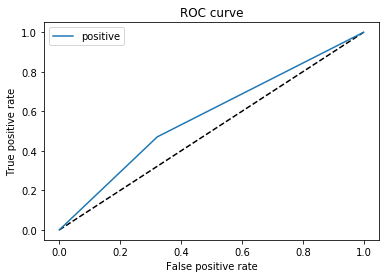

negative
AUC:   0.7561054592287326


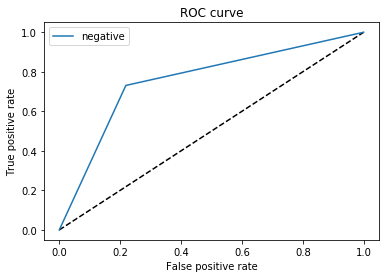

neutral
AUC:   0.6410496256943468


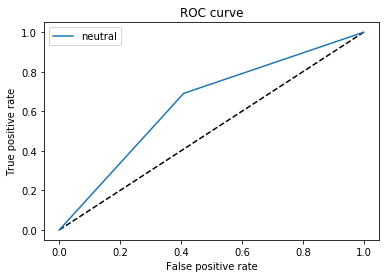

In [110]:
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)
X = vectorizer.fit_transform(df_train.tweet)


#Prediciton with NB
#conmatrxSVC = []
#precisionSVC = []
#recallSVC = []
#f1SVC = []


for category in categories:
    if category == 'positive':
        clf_tunedSVC = LinearSVC(random_state=42, loss='squared_hinge', C=1000)
        y_train_pred = cross_val_predict(clf_tunedSVC, X, df_train[category], cv=5)
    if category == 'negative':
        clf_tunedNB = MultinomialNB(alpha=0.00001)
        y_train_pred = cross_val_predict(clf_tunedNB, X, df_train[category], cv=5)
    if category == 'neutral':
        clf_tunedLR = LogisticRegression(penalty='l1', C=0.03359818286283781)
        y_train_pred = cross_val_predict(clf_tunedLR, X, df_train[category], cv=5)

    
    fpr, tpr, _  = roc_curve(df_train[category], y_train_pred)
    auc_score = roc_auc_score(df_train[category], y_train_pred)
    
    print(category)
    print('AUC:  ', auc_score)
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=category)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    


### Conclusion

The best recall for the positive label was obtained with the tuned SVC model. The best recall for the negative label was obtained with the tuned NB model. The best recall for the neutral label was obtained with the tuned LR model. This will be the final model, as the highest recall  and thus, sensitivity, will give us the best classification results for this problem. We want to predict the highest number of tweets in each category and are willing to accept a few incorrect classifications in order to catch all the correct classifications. We can be fairly confident with these numbers as the precision scores are all above 50%, even after tuning for recall. 

## Final training with AUC scores

In [131]:
for category in categories:


    y = df_train[category].values.astype(np.int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Supervised transformation based on gradient boosted trees
    clf_tunedNB = MultinomialNB(alpha=1)
    clf_tunedNB.fit(X_train, y_train)
    
    # The gradient boosted model by itself
    y_pred = clf_tunedNB.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    print(category)
    print(auc, '\n')

positive
0.6058621906840319 

negative
0.759906997550746 

neutral
0.6449127048079506 



In [130]:
for category in categories:


    y = df_train[category].values.astype(np.int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Supervised transformation based on gradient boosted trees
    clf_tunedSVC = LinearSVC(random_state=42, loss='squared_hinge', C=1000)
    clf_tunedSVC.fit(X_train, y_train)
    
    # The gradient boosted model by itself
    y_pred = clf_tunedSVC.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    print(category)
    print(auc, '\n')

positive
0.5756407634533011 

negative
0.6788250614523448 

neutral
0.6111152182950401 



In [195]:

for category in categories:


    y = df_train[category].values.astype(np.int)

    
    
    if category == 'positive':
        clf_tunedLR = LogisticRegression(penalty='l1',C=78.47599703514607)
        X = featurizer.fit_transform(df_train.tweet)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    if category == 'negative':
        clf_tunedLR = LogisticRegression(penalty='l1',C=78.47599703514607)
        X = vectorizer.fit_transform(df_train.tweet)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    if category == 'neutral':
        clf_tunedLR = LogisticRegression(penalty='l1', C=0.615848211066026)
        X = featurizer.fit_transform(df_train.tweet)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
    clf_tunedLR.fit(X_train, y_train)
    
    
    # The gradient boosted model by itself
    y_pred = clf_tunedLR.predict_proba(X_test)[:, 1]
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    print(category)
    print(auc, '\n')
    

positive
0.7075861550791425 

negative
0.8317214832758875 

neutral
0.766716551419367 



In [124]:
for category in categories:


    y = df_train[category].values.astype(np.int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Supervised transformation based on gradient boosted trees
    clf_tunedRF = RandomForestClassifier(random_state=42, n_estimators=16)
    clf_tunedRF.fit(X_train, y_train)
    # The gradient boosted model by itself
    y_pred = clf_tunedRF.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    print(category)
    print(auc, '\n')

positive
0.6382330152234995 

negative
0.8068803554427165 

neutral
0.6995918327858138 



In [162]:
for category in categories:


    y = df_train[category].values.astype(np.int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    if category == 'positive':
        clf_tunedGRD = GradientBoostingClassifier(random_state=42, loss='deviance', n_estimators=200)
        X = featurizer.fit_transform(df_train.tweet)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    if category == 'negative':
        clf_tunedGRD = GradientBoostingClassifier(random_state=42, loss='deviance', n_estimators=200)
        X = vectorizer.fit_transform(df_train.tweet)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    if category == 'neutral':
        clf_tunedGRD= GradientBoostingClassifier(random_state=42, loss='exponential', n_estimators=16)
        X = featurizer.fit_transform(df_train.tweet)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

     
    clf_tunedGRD.fit(X_train, y_train)
    # The gradient boosted model by itself
    y_pred_grd = clf_tunedGRD.predict_proba(X_test)[:, 1]
    fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
    grd_auc = roc_auc_score(y_test, y_pred_grd)
    
    print(category)
    print(grd_auc, '\n')

positive
0.6826309277898024 

negative
0.8460857186607044 

neutral
0.6609290655063806 



In [ ]:
## Ensembled Gradient Boosting and Logistic Regression

In [202]:
for category in categories:

    if category == 'positive':
        grd = GradientBoostingClassifier(random_state=42, loss='deviance', n_estimators=200)
        X = featurizer.fit_transform(df_train.tweet)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)
        grd_lm = LogisticRegression(penalty='l1',C=78.47599703514607)
        grd.fit(X_train, y_train)
        grd_lm.fit((grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
        y_pred_grd_lm = grd_lm.predict(grd.apply(X_test)[:, :, 0])
        fpr, tpr, _ = roc_curve(y_test, y_pred_grd_lm)
        grd_lm_auc = roc_auc_score(y_test, y_pred_grd_lm)
        
    if category == 'negative':
        clf_tunedGRD = GradientBoostingClassifier(random_state=42, loss='deviance', n_estimators=200)
        X = featurizer.fit_transform(df_train.tweet)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)
        grd_lm = LogisticRegression(penalty='l1',C=78.47599703514607)
        grd.fit(X_train, y_train)
        grd_lm.fit((grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
        y_pred_grd_lm = grd_lm.predict(grd.apply(X_test)[:, :, 0])
        fpr, tpr, _ = roc_curve(y_test, y_pred_grd_lm)
        grd_lm_auc = roc_auc_score(y_test, y_pred_grd_lm)
    
    if category == 'neutral':
        clf_tunedGRD= GradientBoostingClassifier(random_state=42, loss='exponential', n_estimators=16)
        X = featurizer.fit_transform(df_train.tweet)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)        
        grd_lm =LogisticRegression(penalty='l1', C=0.615848211066026)
        grd.fit(X_train, y_train)
        grd_lm.fit((grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
        y_pred_grd_lm = grd_lm.predict(grd.apply(X_test)[:, :, 0])
        fpr, tpr, _ = roc_curve(y_test, y_pred_grd_lm)
        grd_lm_auc = roc_auc_score(y_test, y_pred_grd_lm)

    print(category)
    print(grd_lm_auc, '\n')
    


positive
0.64911924145569 

negative
0.6435081340939881 

neutral
0.6533457578574324 



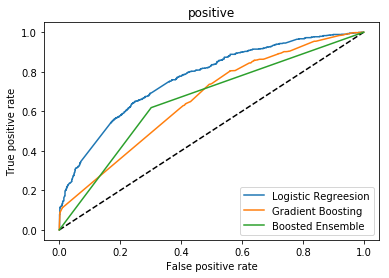

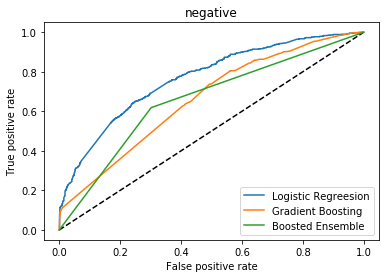

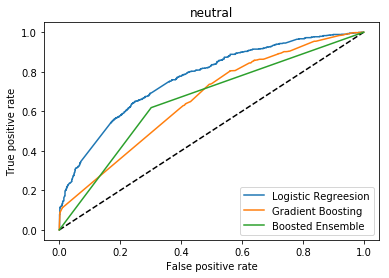

In [201]:

for category in categories:
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lr, tpr_lr, label='Logistic Regreesion')
    plt.plot(fpr_grd, tpr_grd, label='Gradient Boosting')
    plt.plot(fpr, tpr, label='Boosted Ensemble')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(category)
    plt.legend(loc='best')
    plt.show()


## Model Selection

ROC curves are a good choice of visualization when there are roughly equal numbers of observations for each category, such as this data set. While the ensembled model outperformed the gradient boosting model, it did not do better than the logistic regression alone. The best performer for sensitivity is the tuned Logistic Regression model for all three categories. 